In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pmd
from tbats import BATS, TBATS

# Cuidado al usar Prophet. De-registra los convertores de pandas para matplotlib, ocasionando bugs.
from fbprophet import Prophet 

C:\Users\ariel\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\ariel\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [16]:
pd.plotting.register_matplotlib_converters() # Volvemos a registrar los convertores.
plt.rcParams['figure.figsize'] = [16, 4]

### Carga y limpieza de datos

In [17]:
# Cargamos los datos
data_hourly = pd.read_excel("../data/datos.xlsx", sheet_name="Hoja2")
data_hourly.head(10)

,Fecha,Hora UTC,Temp. (ºC),H.Rel (%),Presion/ Geopot.,Dir. vi.,Vel. vi. (Km/h),Nub.,Nubes bajas,Nubes medias,Nubes altas,Prec. (mm),T. max (ºC),T. min (ºC),Situacion
0,01/04/2019,23Z,19.3,86%,1013.2 Hpa,20º (N),11.2,2/8,-,1/8 AC,CI,-,-,-,Algunas nubes
1,01/04/2019,22Z,21.0,77%,1013.0 Hpa,20º (N),13.0,3/8,-,2/8 AC,CI,-,-,-,Nubes dispersas
2,01/04/2019,21Z,25.2,58%,1013.5 Hpa,360º (N),14.8,5/8,-,4/8 AC,CI,-,-,-,Nuboso
3,01/04/2019,20Z,27.0,48%,1013.4 Hpa,360º (N),18.4,5/8,-,4/8 AC,CI,-,-,-,Nuboso
4,01/04/2019,19Z,26.6,47%,1013.5 Hpa,20º (N),18.4,4/8,-,4/8 AC,-,-,-,-,Nubes dispersas
5,01/04/2019,18Z,27.2,40%,1013.8 Hpa,360º (N),20.5,1/8,-,1/8 AC,-,-,-,-,Algunas nubes
6,01/04/2019,17Z,27.0,45%,1014.6 Hpa,360º (N),22.3,1/8,-,1/8 AC,-,-,-,-,Algunas nubes
7,01/04/2019,16Z,26.2,47%,1015.6 Hpa,360º (N),18.4,1/8,-,1/8 AC,-,-,-,-,Algunas nubes
8,01/04/2019,15Z,24.7,50%,1016.0 Hpa,360º (N),14.8,1/8,-,1/8 AC,-,-,-,-,Algunas nubes
9,01/04/2019,14Z,22.8,56%,1016.5 Hpa,360º (N),16.6,1/8,-,1/8 AC,-,-,-,-,Algunas nubes


Comenzamos por combinar las columnas de fecha y hora para crear un indice en formato datetime y acomodamos los nombres de las columnas para acceso más conveniente.

In [18]:
data_hourly["Hora UTC"] = data_hourly["Hora UTC"].map(lambda x: x[:-1])
data_hourly["fecha"] = pd.to_datetime(data_hourly["Fecha"] + " " + data_hourly["Hora UTC"], format="%d/%m/%Y %H")
data_hourly = data_hourly.set_index("fecha").sort_index()
data_hourly = data_hourly.drop(labels=["Hora UTC", "Fecha"], axis=1)
data_hourly.columns = ["temp", "hum", "presion", "dir", "vel", "nub", "n_bajas", "n_medias", "n_altas", "prec", "t_max", "t_min", "situacion"]
data_hourly.head()

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


,temp,hum,presion,dir,vel,nub,n_bajas,n_medias,n_altas,prec,t_max,t_min,situacion
fecha,,,,,,,,,,,,,
2019-04-01 00:00:00,20.1,85%,1016.3 Hpa,070º (E ),14.8,6/8,-,2/8 AC,CI,-,28.9,18.7,Nuboso
2019-04-01 01:00:00,19.2,93%,1016.7 Hpa,70º (E),9.4,4/8,-,-,CI/CS,-,-,-,Nubes dispersas
2019-04-01 02:00:00,18.5,95%,1016.7 Hpa,70º (E),3.6,0/8,-,-,-,-,-,-,Despejado
2019-04-01 03:00:00,15.2,96%,1016.7 Hpa,180º (S),5.4,0/8,-,-,-,-,-,-,"Despejado, neblina"
2019-04-01 04:00:00,16.2,95%,1016.3 Hpa,110º (E),7.6,4/8,-,-,CI/CS,-,-,-,"Nubes dispersas, neblina"


Revisamos los valores faltantes.

In [19]:
data_hourly.isna().sum()

temp          4
hum           6
presion       0
dir           0
vel          10
nub           0
n_bajas       0
n_medias      0
n_altas       0
prec          0
t_max         0
t_min         0
situacion     0
dtype: int64

Ahora vamos a transformar algunas columnas. Para procesarlas vamos a tener que asegurarnos de que sigan un formato coherente. Nos fijamos qué observaciones siguen un patrón diferente y vemos si las descartamos o podemos arreglarlas. Luego aplicamos la transformación.

#### Humedad

In [20]:
# Observaciones donde la columna humedad no sigue el formato esperado.
mask = ~data_hourly.hum.str.match("^\d{,3}\%$", na=False)
data_hourly[mask]

,temp,hum,presion,dir,vel,nub,n_bajas,n_medias,n_altas,prec,t_max,t_min,situacion
fecha,,,,,,,,,,,,,
2019-05-26 15:00:00,10.2,NaN,1011.2 Hpa,320º (NW),9.3,8/8,6/8 SC,AC,N/D,-,-,-,Cubierto
2019-06-21 11:00:00,3.4,NaN,1019.5 Hpa,calma,NaN,5/8,-,-,CI,-,-,-,"Nuboso, niebla"
2019-06-22 12:00:00,7.8,NaN,1019.3 Hpa,230º (SW),7.4,6/8,-,-,CI,-,10.5,24.0,"Nuboso, neblina"
2019-06-27 23:00:00,4.1,NaN,1010.5 Hpa,360º (N ),9.3,8/8,-,5/8 AC,CI,-,-,-,Cubierto
2019-07-09 17:00:00,4.6,NaN,1020.9 Hpa,320º (NW),5.6,4/8,-,-,CI,-,-,-,Nubes dispersas
2019-08-06 07:00:00,3.4,NaN,1013.8 Hpa,340º (N ),11.1,0/8,-,-,-,-,-,-,Despejado


La columna de humedad no tiene problemas, solo datos faltantes, así que la transformamos a numérico.

In [21]:
data_hourly.hum = pd.to_numeric(data_hourly.hum.str.strip("%"))
data_hourly.head()

,temp,hum,presion,dir,vel,nub,n_bajas,n_medias,n_altas,prec,t_max,t_min,situacion
fecha,,,,,,,,,,,,,
2019-04-01 00:00:00,20.1,85.0,1016.3 Hpa,070º (E ),14.8,6/8,-,2/8 AC,CI,-,28.9,18.7,Nuboso
2019-04-01 01:00:00,19.2,93.0,1016.7 Hpa,70º (E),9.4,4/8,-,-,CI/CS,-,-,-,Nubes dispersas
2019-04-01 02:00:00,18.5,95.0,1016.7 Hpa,70º (E),3.6,0/8,-,-,-,-,-,-,Despejado
2019-04-01 03:00:00,15.2,96.0,1016.7 Hpa,180º (S),5.4,0/8,-,-,-,-,-,-,"Despejado, neblina"
2019-04-01 04:00:00,16.2,95.0,1016.3 Hpa,110º (E),7.6,4/8,-,-,CI/CS,-,-,-,"Nubes dispersas, neblina"


#### Presion

In [22]:
# Observaciones donde la presión no sigue el patrón que debería
mask = ~data_hourly.presion.str.match("^\s*\d{3,4}[.]\d\s*Hpa\s*$", na=False)
data_hourly[mask]

,temp,hum,presion,dir,vel,nub,n_bajas,n_medias,n_altas,prec,t_max,t_min,situacion
fecha,,,,,,,,,,,,,
2019-06-23 00:00:00,17.6,62.0,-,320º (NW),3.7,7/8,-,-,CI,-,19.1,8.2,"Nuboso, neblina"
2019-06-28 10:00:00,4.4,89.0,-,180º (S),9.4,6/8,-,1/8 AC,CI/CS,-,-,-,Nuboso
2019-07-16 01:00:00,2.8,86.0,234 m (1000 Hpa),200º (S),5.4,0/8,-,-,-,-,-,-,Despejado
2019-07-25 13:00:00,3.0,62.0,-,110º (E ),7.4,7/8,-,2/8 AC,CI,-,-,-,Nuboso
2019-09-03 05:00:00,23.7,17.0,-,230º (SW),18.5,0/8,-,-,-,-,-,-,Despejado


Tenemos un valor con un formato diferente al resto y datos faltantes. Solo nos interesa el valor numérico, así que lo extraemos y asignamos NA a las observaciones problemáticas.

In [23]:
ext = data_hourly.presion.str.extract("^\s*(\d{3,4}[.]\d)\s*Hpa\s*$") # Extrae y asigna NA a las que no coinciden con el patrón.
data_hourly.presion = pd.to_numeric(ext[0])
data_hourly.head()

,temp,hum,presion,dir,vel,nub,n_bajas,n_medias,n_altas,prec,t_max,t_min,situacion
fecha,,,,,,,,,,,,,
2019-04-01 00:00:00,20.1,85.0,1016.3,070º (E ),14.8,6/8,-,2/8 AC,CI,-,28.9,18.7,Nuboso
2019-04-01 01:00:00,19.2,93.0,1016.7,70º (E),9.4,4/8,-,-,CI/CS,-,-,-,Nubes dispersas
2019-04-01 02:00:00,18.5,95.0,1016.7,70º (E),3.6,0/8,-,-,-,-,-,-,Despejado
2019-04-01 03:00:00,15.2,96.0,1016.7,180º (S),5.4,0/8,-,-,-,-,-,-,"Despejado, neblina"
2019-04-01 04:00:00,16.2,95.0,1016.3,110º (E),7.6,4/8,-,-,CI/CS,-,-,-,"Nubes dispersas, neblina"


#### Dirección del viento

In [24]:
# Observaciones de dirección con formato diferente al esperado.
mask = ~data_hourly.dir.str.match("^\s*\d{1,3}.\s*[(]\s*[NESW]{,2}\s*[)]\s*$", na=False)
data_hourly[mask]

,temp,hum,presion,dir,vel,nub,n_bajas,n_medias,n_altas,prec,t_max,t_min,situacion
fecha,,,,,,,,,,,,,
2019-04-01 06:00:00,15.6,96.0,1015.8,calma,NaN,5/8,-,2/8 AC,CI,-,-,-,"Nuboso, neblina"
2019-06-01 06:00:00,7.1,93.0,1016.8,calma,NaN,8/8,-,8/8 AC,N/D,-,-,-,Cubierto
2019-06-21 11:00:00,3.4,NaN,1019.5,calma,NaN,5/8,-,-,CI,-,-,-,"Nuboso, niebla"
2019-06-22 00:00:00,9.9,93.0,1019.5,calma,NaN,7/8,-,4/8 AC,CI,-,14.2,3.2,Nuboso
2019-07-07 12:00:00,-0.4,95.0,1026.9,calma,NaN,5/8,-,-,CI,-,2.0,-4.8,Nuboso
2019-07-31 09:00:00,3.9,100.0,1010.3,calma,NaN,2/8,-,-,CI,-,-,-,"Algunas nubes, niebla"
2019-08-10 12:00:00,-0.4,95.0,1017.1,calma,NaN,0/8,-,-,-,-,1.4,-4.6,Despejado
2019-08-22 12:00:00,4.8,93.0,1030.6,calma,NaN,8/8,-,8/8 AC,N/D,0.2(24h),5.0,2.5,Cubierto
2019-08-26 12:00:00,9.4,93.0,1018.7,calma,NaN,0/8,-,-,-,-,9.6,3.6,"Despejado, niebla"


Nos quedamos solo con el punto cardinal y le asignamos "-" a la dirección en aquellas observaciones que corresponden a días sin viento, como también cero a la velocidad.

In [25]:
ext = data_hourly.dir.str.extract("^\s*\d{1,3}.\s*[(]\s*([NESW]{,2})\s*[)]\s*$")
data_hourly.loc[data_hourly.dir != "calma", "dir"] = ext[0]
data_hourly.loc[data_hourly.dir == "calma", ["dir", "vel"]] = ["-", 0]

Comprobamos si los días con velocidad cero coinciden con aquellos días con dirección nula.

In [26]:
(data_hourly.vel == 0).equals(data_hourly.dir == "-")

False

No coinciden, así que lo revisamos mejor.

In [27]:
data_hourly[(data_hourly.vel == 0) != (data_hourly.dir == "-")].head(10)

,temp,hum,presion,dir,vel,nub,n_bajas,n_medias,n_altas,prec,t_max,t_min,situacion
fecha,,,,,,,,,,,,,
2019-04-01 05:00:00,16.0,96.0,1016.6,N,0.0,4/8,-,-,CI/CS,-,-,-,"Nubes dispersas, neblina"
2019-04-02 02:00:00,17.2,93.0,1012.8,N,0.0,0/8,-,-,-,-,-,-,Despejado
2019-04-03 05:00:00,9.0,96.0,1014.8,N,0.0,0/8,-,-,-,-,-,-,Despejado
2019-04-04 00:00:00,12.9,73.0,1007.1,N,0.0,0/8,-,-,-,-,23.4,11.9,Despejado
2019-04-05 21:00:00,18.2,47.0,1020.2,N,0.0,0/8,-,-,-,-,-,-,Despejado
2019-04-05 22:00:00,14.1,67.0,1020.7,N,0.0,0/8,-,-,-,-,-,-,Despejado
2019-04-06 00:00:00,8.6,87.0,1021.6,N,0.0,0/8,-,-,-,-,20.0,8.6,Despejado
2019-04-06 01:00:00,7.7,87.0,1022.1,N,0.0,0/8,-,-,-,-,-,-,Despejado
2019-04-06 02:00:00,6.6,88.0,1022.2,N,0.0,0/8,-,-,-,-,-,-,Despejado


Parece que en casi todos los días con velocidad cero la dirección asignada fue N(0°).

In [28]:
data_hourly[data_hourly.vel == 0].dir.unique()

array(['N', '-'], dtype=object)

En efecto, ese es el caso, por lo que procedemos a reemplazar todos esos N con "-".

In [29]:
data_hourly.loc[data_hourly.vel == 0, "dir"] = "-"

#### Nubosidad

In [30]:
data_hourly.nub.unique()

array(['6/8 ', '4/8', '0/8', '5/8 ', '7/8', '6/8', '3/8', '5/8', '1/8',
       '2/8', '2/8 ', 'N/D', '8/8', '8/8 ', '0/8 ', '7/8 ', '3/8 ',
       '1/8 ', '4/8 ', 'N/D '], dtype=object)

Hay algunos espacios al final y valores no disponibles. Ya sabemos que la humedad está medida en octas, por lo que no quedamos con el numerador solamente y asignamos -1 a los valores "N/D" y pasamos a numérico.

In [31]:
#data_hourly.nub = data_hourly.nub.str.strip()
data_hourly.nub = data_hourly.nub.apply(lambda x: x[0])
data_hourly.loc[data_hourly.nub == "N", "nub"] = 9

In [32]:
data_hourly.nub = pd.to_numeric(data_hourly.nub)

In [33]:
data_hourly.head()

,temp,hum,presion,dir,vel,nub,n_bajas,n_medias,n_altas,prec,t_max,t_min,situacion
fecha,,,,,,,,,,,,,
2019-04-01 00:00:00,20.1,85.0,1016.3,E,14.8,6,-,2/8 AC,CI,-,28.9,18.7,Nuboso
2019-04-01 01:00:00,19.2,93.0,1016.7,E,9.4,4,-,-,CI/CS,-,-,-,Nubes dispersas
2019-04-01 02:00:00,18.5,95.0,1016.7,E,3.6,0,-,-,-,-,-,-,Despejado
2019-04-01 03:00:00,15.2,96.0,1016.7,S,5.4,0,-,-,-,-,-,-,"Despejado, neblina"
2019-04-01 04:00:00,16.2,95.0,1016.3,E,7.6,4,-,-,CI/CS,-,-,-,"Nubes dispersas, neblina"


In [34]:
data_hourly.nub.unique()

array([6, 4, 0, 5, 7, 3, 1, 2, 9, 8], dtype=int64)

Una inspección a las observaciones con valores -1 de nubosidad resulta ser reveladora. Ese valor corresponde a días de niebla.

In [35]:
data_hourly[data_hourly.nub == 9].head(10)

,temp,hum,presion,dir,vel,nub,n_bajas,n_medias,n_altas,prec,t_max,t_min,situacion
fecha,,,,,,,,,,,,,
2019-04-02 10:00:00,17.9,98.0,1010.7,NW,11.2,9,-,-,-,-,-,-,Niebla
2019-04-02 11:00:00,17.6,100.0,1010.9,NW,11.2,9,-,-,-,-,-,-,Niebla
2019-04-02 12:00:00,18.0,100.0,1010.6,N,11.2,9,-,-,-,-,19.2,15.0,Niebla
2019-04-02 13:00:00,19.6,100.0,1010.6,NW,13.0,9,-,-,-,-,-,-,Niebla
2019-04-04 08:00:00,11.9,100.0,1001.0,N,3.6,9,-,-,-,-,-,-,Niebla
2019-04-04 09:00:00,12.6,100.0,1000.9,N,7.6,9,-,-,-,-,-,-,Niebla
2019-04-04 10:00:00,13.2,98.0,1000.6,E,7.6,9,-,-,-,-,-,-,Niebla
2019-05-04 05:00:00,10.7,96.0,1015.4,E,16.6,9,-,-,-,-,-,-,Niebla
2019-05-04 06:00:00,11.9,98.0,1016.3,E,14.8,9,-,-,-,-,-,-,Niebla


In [36]:
data_hourly[data_hourly.nub == -1].situacion.unique()

array([], dtype=object)

#### Precipitaciones

In [37]:
data_hourly.prec.unique()

array(['-', '17.0(24h)', '11.0(6h)', '2.0(6h)', '12.0(24h)', '20.0(6h)',
       '0.6(6h)', '21.0(24h)', '4.0(24h)', '6.0(6h)', '3.0(6h)',
       '8.0(24h)', 'Ip(24h)', 'Ip(6h)', '1.0(6h)', '18.0(6h)',
       '22.0(24h)', '0.2(6h)', '0.7(6h)', '0.9(24h)', '3.0(24h)',
       '23.0(6h)', '5.0(6h)', '28.0(24h)', '45.0(24h)', '0.5(6h)',
       '0.6(24h)', '35.0(6h)', '39.0(24h)', '13.0(24h)', '27.0(6h)',
       '13.0(6h)', '56.0(24h)', '0.4(6h)', ' 0.8(6h) ', '2.0(24h)',
       '0.3(6h)', '62.0(12h)', ' 0.2(24h)', '5.0(24h)'], dtype=object)

In [38]:
data_hourly.loc[~data_hourly.prec.str.match("\s*(\d{,2}.\d).*", na=False), "prec"].unique()

array(['-', 'Ip(24h)', 'Ip(6h)'], dtype=object)

La columna de precipitacion contiene la combinación de dos valores: la cantidad en mm y lo que parece ser una aproximación al número de horas que ha estado precipitando. También hay un valor denominado "Ip" que corresponde a precipitaciones inapreciables. Lo que vamos a hacer es quedarnos solo con la información numérica de la precipitacion en mm y descartar todo lo demás. A las celdas con "-" y "Ip" le vamos a asignar 0.

In [39]:
mask = (data_hourly.prec == "Ip(24h)") | (data_hourly.prec == "Ip(6h)") | (data_hourly.prec == "-")
data_hourly.loc[mask, "prec"] = 0.0

In [40]:
extr = data_hourly.prec.str.extract("\s*(\d{,2}.\d).*")[0]

In [41]:
data_hourly.loc[~extr.isna(), "prec"] = extr.dropna()

In [42]:
data_hourly.prec = pd.to_numeric(data_hourly.prec)

In [43]:
data_hourly.prec.unique()

array([ 0. , 17. , 11. ,  2. , 12. , 20. ,  0.6, 21. ,  4. ,  6. ,  3. ,
        8. ,  1. , 18. , 22. ,  0.2,  0.7,  0.9, 23. ,  5. , 28. , 45. ,
        0.5, 35. , 39. , 13. , 27. , 56. ,  0.4,  0.8,  0.3, 62. ])

#### Temperaturas máximas y mínimas

In [44]:
data_hourly.loc[:, ["temp", "t_max", "t_min"]].head(25)

,temp,t_max,t_min
fecha,,,
2019-04-01 00:00:00,20.1,28.9,18.7
2019-04-01 01:00:00,19.2,-,-
2019-04-01 02:00:00,18.5,-,-
2019-04-01 03:00:00,15.2,-,-
2019-04-01 04:00:00,16.2,-,-
2019-04-01 05:00:00,16.0,-,-
2019-04-01 06:00:00,15.6,-,-
2019-04-01 07:00:00,15.2,-,-
2019-04-01 08:00:00,15.0,-,-


Las temperaturas máximas y mínimas se anotan al final del período correspondiente. Por lo tanto podemos reemplazar todos los "-" con NA y después realizar un backfill.

In [45]:
data_hourly.loc[data_hourly.t_max == "-", "t_max"] = np.nan
data_hourly.loc[data_hourly.t_min == "-", "t_min"] = np.nan

In [46]:
data_hourly.t_max = pd.to_numeric(data_hourly.t_max)
data_hourly.t_min = pd.to_numeric(data_hourly.t_min)

In [47]:
data_hourly.t_max = data_hourly.t_max.fillna(method="bfill")
data_hourly.t_min = data_hourly.t_min.fillna(method="bfill")

In [48]:
data_hourly.head()

,temp,hum,presion,dir,vel,nub,n_bajas,n_medias,n_altas,prec,t_max,t_min,situacion
fecha,,,,,,,,,,,,,
2019-04-01 00:00:00,20.1,85.0,1016.3,E,14.8,6,-,2/8 AC,CI,0.0,28.9,18.7,Nuboso
2019-04-01 01:00:00,19.2,93.0,1016.7,E,9.4,4,-,-,CI/CS,0.0,20.1,12.5,Nubes dispersas
2019-04-01 02:00:00,18.5,95.0,1016.7,E,3.6,0,-,-,-,0.0,20.1,12.5,Despejado
2019-04-01 03:00:00,15.2,96.0,1016.7,S,5.4,0,-,-,-,0.0,20.1,12.5,"Despejado, neblina"
2019-04-01 04:00:00,16.2,95.0,1016.3,E,7.6,4,-,-,CI/CS,0.0,20.1,12.5,"Nubes dispersas, neblina"


#### Nubes bajas, medias y altas

Por último, las columnas con los datos de nubosidad baja, media y alta no nos interesan, así que las tiramos.

In [49]:
data_hourly = data_hourly.drop(columns=["n_bajas", "n_medias", "n_altas"])

In [50]:
data_hourly.head()

,temp,hum,presion,dir,vel,nub,prec,t_max,t_min,situacion
fecha,,,,,,,,,,
2019-04-01 00:00:00,20.1,85.0,1016.3,E,14.8,6,0.0,28.9,18.7,Nuboso
2019-04-01 01:00:00,19.2,93.0,1016.7,E,9.4,4,0.0,20.1,12.5,Nubes dispersas
2019-04-01 02:00:00,18.5,95.0,1016.7,E,3.6,0,0.0,20.1,12.5,Despejado
2019-04-01 03:00:00,15.2,96.0,1016.7,S,5.4,0,0.0,20.1,12.5,"Despejado, neblina"
2019-04-01 04:00:00,16.2,95.0,1016.3,E,7.6,4,0.0,20.1,12.5,"Nubes dispersas, neblina"


### Datos faltantes

Verificamos qué columnas tienen datos faltantes.

In [51]:
data_hourly.isna().sum()

temp         4
hum          6
presion      5
dir          0
vel          0
nub          0
prec         0
t_max        7
t_min        7
situacion    0
dtype: int64

Revisamos los valores faltantes de temperatura.

In [52]:
data_hourly[data_hourly.temp.isna()]

,temp,hum,presion,dir,vel,nub,prec,t_max,t_min,situacion
fecha,,,,,,,,,,
2019-06-22 21:00:00,NaN,0.0,1017.4,N,57.4,1,0.0,19.1,8.2,Algunas nubes
2019-06-23 10:00:00,NaN,0.0,1012.4,N,122.3,1,0.0,10.4,4.0,Algunas nubes
2019-07-26 21:00:00,NaN,0.0,1020.8,S,11.1,5,0.0,14.0,5.2,Nuboso
2019-08-30 00:00:00,NaN,0.0,1015.9,N,113.0,1,0.0,16.0,6.0,Algunas nubes


Esas observaciones tienen valores nulos en la columna de humedad. Nos fijamos si las observaciones con humedad 0 son las mismas.

In [53]:
data_hourly[data_hourly.temp.isna()].equals(data_hourly[data_hourly.hum == 0])

True

Claramente los valores de humedad cero en realidad corresponden a mediciones faltantes, así que los representamos como tal.

In [54]:
data_hourly.loc[data_hourly.hum == 0, "hum"] = np.nan

Ahora revisamos los datos faltantes en la columna de humedad.

In [55]:
data_hourly[data_hourly.hum.isna()]

,temp,hum,presion,dir,vel,nub,prec,t_max,t_min,situacion
fecha,,,,,,,,,,
2019-05-26 15:00:00,10.2,NaN,1011.2,NW,9.3,8,0.0,10.2,8.2,Cubierto
2019-06-21 11:00:00,3.4,NaN,1019.5,-,0.0,5,0.0,7.3,2.2,"Nuboso, niebla"
2019-06-22 12:00:00,7.8,NaN,1019.3,SW,7.4,6,0.0,10.5,24.0,"Nuboso, neblina"
2019-06-22 21:00:00,NaN,NaN,1017.4,N,57.4,1,0.0,19.1,8.2,Algunas nubes
2019-06-23 10:00:00,NaN,NaN,1012.4,N,122.3,1,0.0,10.4,4.0,Algunas nubes
2019-06-27 23:00:00,4.1,NaN,1010.5,N,9.3,8,0.0,11.6,3.9,Cubierto
2019-07-09 17:00:00,4.6,NaN,1020.9,NW,5.6,4,0.0,16.2,5.3,Nubes dispersas
2019-07-26 21:00:00,NaN,NaN,1020.8,S,11.1,5,0.0,14.0,5.2,Nuboso
2019-08-06 07:00:00,3.4,NaN,1013.8,N,11.1,0,0.0,10.0,3.0,Despejado


Revisamos los datos faltantes de presión.

In [56]:
data_hourly[data_hourly.presion.isna()]

,temp,hum,presion,dir,vel,nub,prec,t_max,t_min,situacion
fecha,,,,,,,,,,
2019-06-23 00:00:00,17.6,62.0,NaN,NW,3.7,7,0.0,19.1,8.2,"Nuboso, neblina"
2019-06-28 10:00:00,4.4,89.0,NaN,S,9.4,6,0.0,8.5,2.0,Nuboso
2019-07-16 01:00:00,2.8,86.0,NaN,S,5.4,0,0.0,3.3,-3.8,Despejado
2019-07-25 13:00:00,3.0,62.0,NaN,E,7.4,7,0.0,9.5,0.6,Nuboso
2019-09-03 05:00:00,23.7,17.0,NaN,SW,18.5,0,0.0,2.5,-2.8,Despejado


Revisamos si hay fechas faltantes.

In [57]:
start = data_hourly.index[0]
end = data_hourly.index[-1]
missing_dates = pd.date_range(start=start, end=end, freq="H").difference(data_hourly.index)
print("Hay {} valores faltantes en las observaciones.".format(len(missing_dates)))
print("Los días y horas que faltan son:")
missing_dates

Hay 73 valores faltantes en las observaciones.
Los días y horas que faltan son:


DatetimeIndex(['2019-04-02 04:00:00', '2019-04-25 07:00:00',
               '2019-05-22 07:00:00', '2019-05-23 02:00:00',
               '2019-05-23 04:00:00', '2019-05-23 08:00:00',
               '2019-05-27 17:00:00', '2019-06-13 13:00:00',
               '2019-06-16 07:00:00', '2019-06-16 10:00:00',
               '2019-06-16 11:00:00', '2019-06-16 12:00:00',
               '2019-06-16 13:00:00', '2019-06-16 14:00:00',
               '2019-06-16 15:00:00', '2019-06-16 16:00:00',
               '2019-06-16 17:00:00', '2019-06-16 18:00:00',
               '2019-06-16 19:00:00', '2019-06-16 20:00:00',
               '2019-06-16 21:00:00', '2019-06-16 22:00:00',
               '2019-06-16 23:00:00', '2019-06-17 00:00:00',
               '2019-06-17 01:00:00', '2019-06-17 02:00:00',
               '2019-06-17 03:00:00', '2019-06-17 04:00:00',
               '2019-06-17 05:00:00', '2019-06-17 06:00:00',
               '2019-06-17 07:00:00', '2019-06-17 08:00:00',
               '2019-06-

Le decimos a pandas que ponga los datos en frecuencia horaria, creando NA para los valores que faltan.

In [58]:
data_hourly = data_hourly.asfreq("H")
data_hourly.isna().sum()

temp         77
hum          83
presion      78
dir          73
vel          73
nub          73
prec         73
t_max        80
t_min        80
situacion    73
dtype: int64

Agregamos una columna que nos dice si la fila corresponde a una de las fechas faltantes.

In [59]:
# index = data_hourly.index
# data_hourly["hora"] = index.hour
# data_hourly["dia_mes"] = index.day
# data_hourly["dia_año"] = index.dayofyear 
# data_hourly["semana"] = index.week
# data_hourly["mes"] = index.month
data_hourly["faltante"] = data_hourly.index.map(lambda x: x in missing_dates)
data_hourly.head()

,temp,hum,presion,dir,vel,nub,prec,t_max,t_min,situacion,faltante
fecha,,,,,,,,,,,
2019-04-01 00:00:00,20.1,85.0,1016.3,E,14.8,6.0,0.0,28.9,18.7,Nuboso,False
2019-04-01 01:00:00,19.2,93.0,1016.7,E,9.4,4.0,0.0,20.1,12.5,Nubes dispersas,False
2019-04-01 02:00:00,18.5,95.0,1016.7,E,3.6,0.0,0.0,20.1,12.5,Despejado,False
2019-04-01 03:00:00,15.2,96.0,1016.7,S,5.4,0.0,0.0,20.1,12.5,"Despejado, neblina",False
2019-04-01 04:00:00,16.2,95.0,1016.3,E,7.6,4.0,0.0,20.1,12.5,"Nubes dispersas, neblina",False


Podemos crear una gráfica para ver como se distribuyen las fechas faltantes.

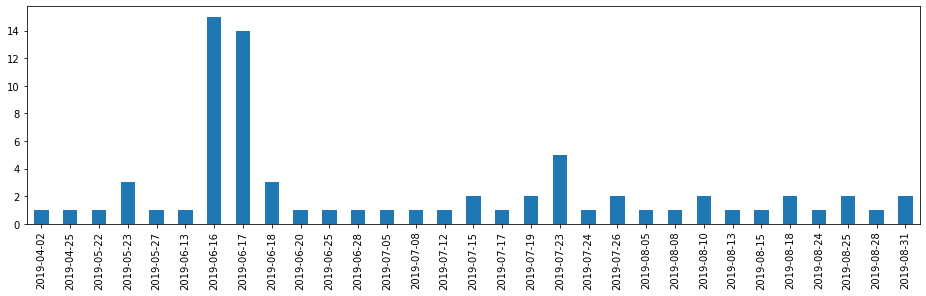

In [60]:
tmp = data_hourly.groupby(data_hourly.index.date)["faltante"].sum()
tmp = tmp[tmp != 0]
tmp.plot(kind="bar")

Los días 2019-06-16 y 2019-06-17 son los que registran un mayor número de valores faltantes. Si graficamos algunas de las series temporales...

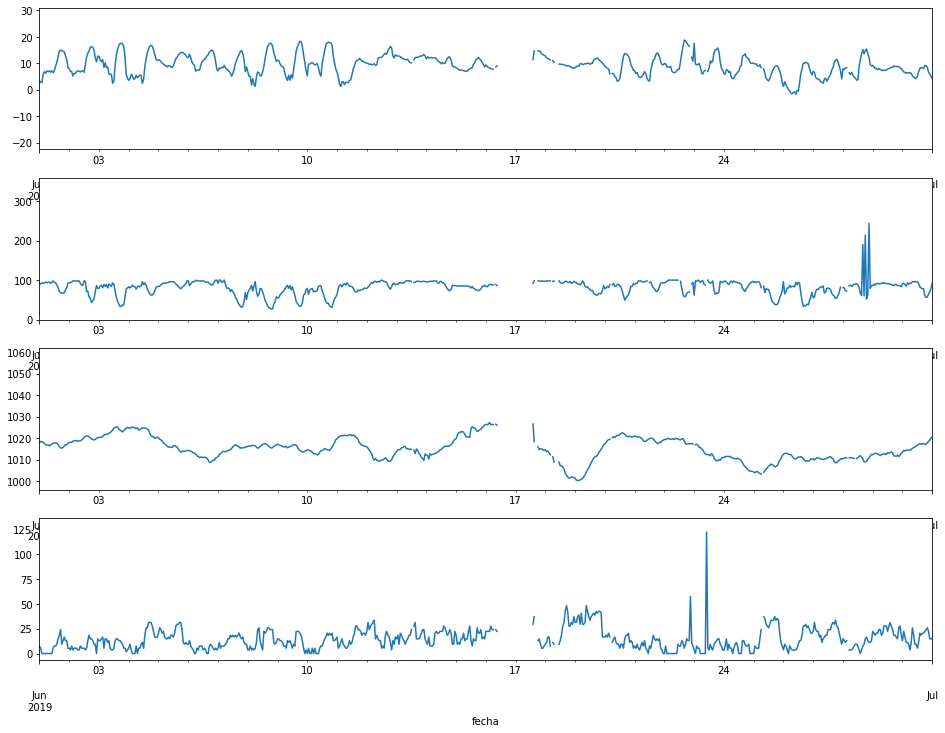

In [61]:
f, ax = plt.subplots(4, 1, figsize=(16,12))
data_hourly.temp.plot(xlim=("2019-06", "2019-07"), ax=ax[0])
data_hourly.hum.plot(xlim=("2019-06", "2019-07"), ax=ax[1])
data_hourly.presion.plot(xlim=("2019-06", "2019-07"), ax=ax[2])
data_hourly.vel.plot(xlim=("2019-06", "2019-07"), ax=ax[3])

...queda claro que esos valores faltantes son consecutivos. También parece que el intervalo entre el día 11 y 20 de junio presenta un patrón diferente al resto del mes. En particular, las oscilaciones diarias de temperatura y humedad disminuyen notablemente. Eso es extraño, y sumado a la gran cantidad de observaciones faltantes, podría indicar un problema con las mediciones de ese período.

Vamos a revisar las series de temperatura y humedad para cada uno de los meses por separado.

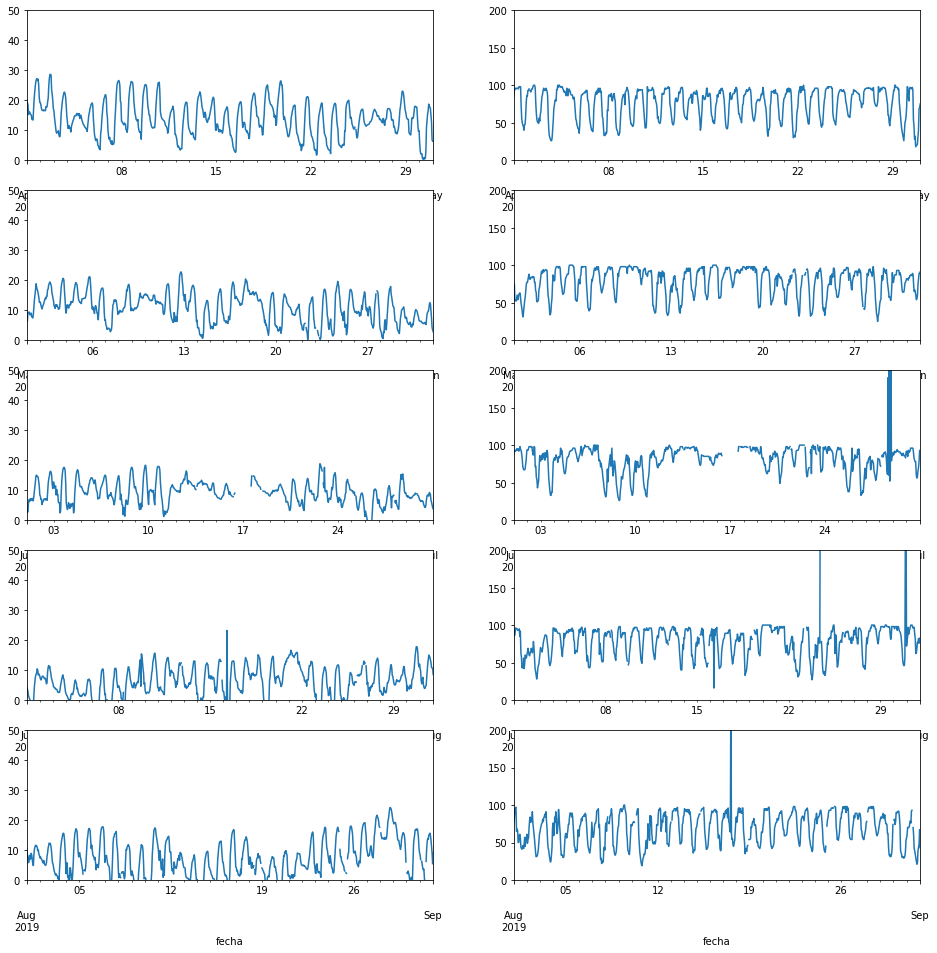

In [62]:
f, ax = plt.subplots(nrows=5, ncols=2, figsize=(16,16))
dates = pd.date_range(start="2019-04", end="2019-09", freq="MS")
for k in range(len(dates)-1):
    data_hourly.temp.plot(kind="line", xlim=(dates[k], dates[k+1]), ax=ax[k,0], ylim=(0,50));
    data_hourly.hum.plot(kind="line", xlim=(dates[k], dates[k+1]), ax=ax[k,1], ylim=(0,200));

In [63]:
data_hourly.isna().sum()

temp         77
hum          83
presion      78
dir          73
vel          73
nub          73
prec         73
t_max        80
t_min        80
situacion    73
faltante      0
dtype: int64

## Pronóstico

In [64]:
potencia = pd.read_csv("../data/potencia.csv", parse_dates=["fecha"], index_col="fecha")

In [65]:
potencia.head()

,potencia
fecha,
2019-05-30 12:45:00,975
2019-05-30 12:46:00,1003
2019-05-30 12:47:00,1007
2019-05-30 12:48:00,989
2019-05-30 12:49:00,800


In [66]:
potencia = potencia.rename(columns={"potencia":"y"})

In [67]:
data = potencia.resample("H").mean()

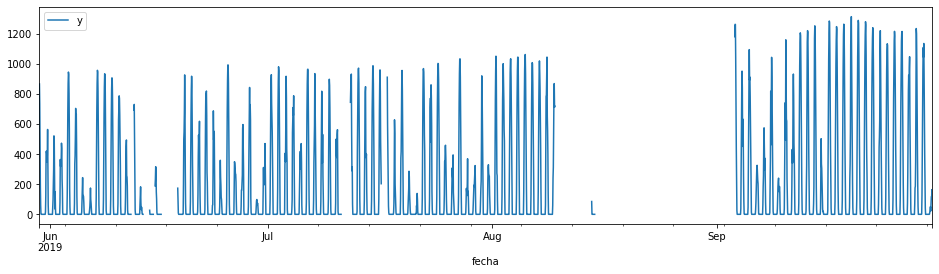

In [68]:
data.plot()

In [69]:
#potencia_h["hora"] = potencia_h.index.hour
data["gen"] = (data.index.hour.isin(range(8,18))).astype("int64")

In [70]:
data.tail()

,y,gen
fecha,,
2019-09-30 13:00:00,66.600000,1
2019-09-30 14:00:00,117.566667,1
2019-09-30 15:00:00,119.033333,1
2019-09-30 16:00:00,164.083333,1
2019-09-30 17:00:00,104.500000,1


In [71]:
dummy = pd.DataFrame()
dummy["sky1"] = (data_hourly.nub.isin([2,3]))
dummy["sky2"] = (data_hourly.nub.isin([4,5]))
dummy["sky3"] = (data_hourly.nub.isin([6,7]))
dummy["sky4"] = (data_hourly.nub.isin([8,9]))

In [72]:
dummy = dummy.astype("int64")

In [73]:
data = data.merge(dummy, right_index=True, left_index=True)

In [74]:
data.index.name = "ds"

In [75]:
train = data.loc["2019-06":"2019-07-25"].copy()
test = data.loc["2019-07-26":"2019-08-07"].copy()

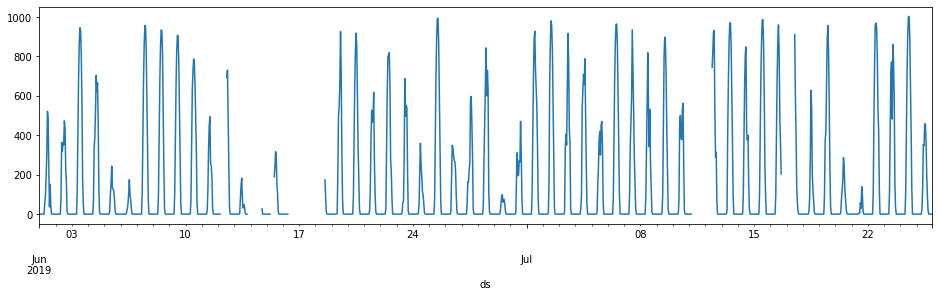

In [76]:
train.y.plot()

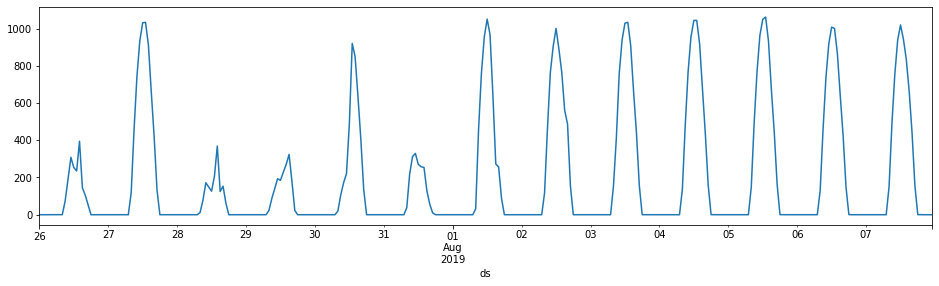

In [77]:
test.y.plot()

In [78]:
train_list = []
test_list = []
for k in range(8, 18):
    train_list.append(train.loc[train.index.hour == k, :].reset_index())
    test_list.append(test.loc[test.index.hour == k, :].reset_index())

In [79]:
models = []
forecasts = []
exogs = ['sky1', 'sky2', 'sky3', 'sky4']
for k in range(len(train_list)):
    train_data = train_list[k]
    test_data = test_list[k]
    m = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False, 
                        holidays_prior_scale=10.0, seasonality_mode="additive")
    for exog in exogs:
        m.add_regressor(exog)
        
    m.fit(train_data)
    
    future = m.make_future_dataframe(periods=len(test_data), freq="D")
    
    regressors = pd.concat([train_data[exogs], test_data[exogs]], ignore_index=True)
    future = future.merge(regressors, left_index=True, right_index=True)
    forecasts.append(m.predict(future).copy())
    models.append(m)

In [80]:
fcst = pd.concat(forecasts).set_index("ds").sort_index()

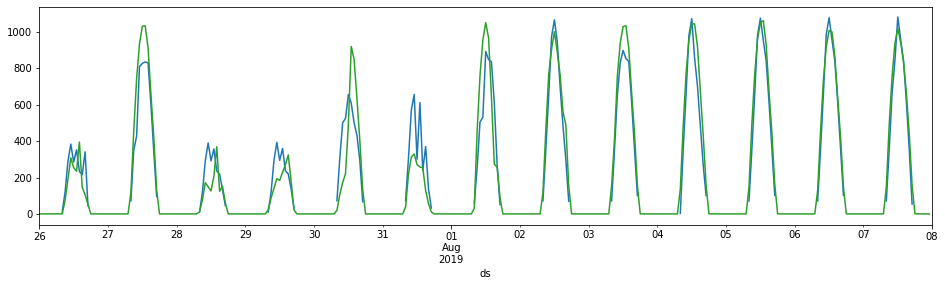

In [81]:
fcst.yhat.asfreq("H").plot()
train.y.plot()
test.y.plot(xlim=("2019-07-26", "2019-08-08"))

In [82]:
models

### Selective Moving Average

In [85]:
df = train_list[5]

In [90]:
df.tail()

,ds,y,gen,sky1,sky2,sky3,sky4
50,2019-07-21 13:00:00,57.600000,1,0,0,0,1
51,2019-07-22 13:00:00,946.333333,1,0,1,0,0
52,2019-07-23 13:00:00,860.550000,1,1,0,0,0
53,2019-07-24 13:00:00,1000.666667,1,0,0,0,0
54,2019-07-25 13:00:00,459.000000,1,0,0,1,0


In [ ]:
df.loc[df.]